<a href="https://colab.research.google.com/github/MLP-deepdreamteam/Practice_captioning/blob/branch_%EA%B9%80%EC%9C%A4%EC%84%B1/coco_custom30k_image_feature_extraction(230411_VGG16_features)_model_aug(false)V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pycocotools.coco import COCO # COCO python library
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import random
import string

import cv2
import os
from pickle import dump, load
import json

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from keras.layers import add

from tensorflow.keras.models import Model, load_model

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model

In [ ]:
from google.colab import auth
auth.authenticate_user()

### 드라이브 마운트 & os확인

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#  gs://coco_custom30k/custom30k.zip

/bin/bash: gs://coco_custom30k/custom30k.zip: No such file or directory


In [ ]:
from zipfile import ZipFile

In [ ]:
# !wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip # 전체롤드

In [ ]:
! gsutil cp gs://coco_custom30k/custom30k.zip /content/coco_custom30k

Copying gs://coco_custom30k/custom30k.zip...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1 files][  4.6 GiB/  4.6 GiB]  171.5 MiB/s                                   
Operation completed over 1 objects/4.6 GiB.                                      


In [ ]:
with ZipFile("/content/coco_custom30k") as zfile:
  zfile.extractall(".")

In [ ]:
import os
sample_path ="/content/content/custom_train_coco_30k"
sample_train = os.listdir(sample_path)

# print(sample_train[:3])

In [ ]:
print(len(sample_train), sample_train[:3])

30000 ['000000329035.jpg', '000000193720.jpg', '000000538589.jpg']


In [ ]:
# with GFile("gs://coco_custom30k/custom30k.zipl", "rb") as f:
#     dataset = pickle.load(f)

# Exploring COCO Dataset

#### Initialize COCO class and operate instances_train2017.json

In [ ]:
import pandas as pd
import json
# i = 0
# with open(f'/content/drive/MyDrive/coco_ann2017/annotations/captions_train2017.json', 'r') as f: # 마운트 확인
with open(f'/content/drive/MyDrive/coco_dataset/coco_ann2017/annotations/captions_train2017.json', 'r') as f: # 마운트 확인

    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption'],sample['image_id']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption','image_id'])
captions['image'] = captions['image'].apply(
    lambda x: f'/content/drive/MyDrive/coco_dataset//train2017/{x}'
)
captions = captions.reset_index(drop=True)
print(captions.head(3))



                                               image  \
0  /content/drive/MyDrive/coco_dataset//train2017...   
1  /content/drive/MyDrive/coco_dataset//train2017...   
2  /content/drive/MyDrive/coco_dataset//train2017...   

                                             caption  image_id  
0  A bicycle replica with a clock as the front wh...    203564  
1  A room with blue walls and a white sink and door.    322141  
2  A car that seems to be parked illegally behind...     16977  


In [ ]:
df_captions_in_COCO = captions.groupby(["image", "image_id"])['caption'].apply(list).reset_index()


df_captions_in_COCO.shape


# # display(df_captions_in_COCO)

## sample 30k 생성용 
# # caption 길이가 5 이상이면 drop
# df_captions_in_COCO = df_captions_in_COCO[df_captions_in_COCO['caption'].apply(len) < 6]

# sample_30k  = df_captions_in_COCO.sample(30_000)




(118287, 3)

In [ ]:
# 캡션 내역 확인
df_captions_in_COCO.head()
print(df_captions_in_COCO.shape)

print(
df_captions_in_COCO.iloc[0,0],
"\n",
df_captions_in_COCO.iloc[0,1],
"\n",
df_captions_in_COCO.iloc[0,2])

(118287, 3)
/content/drive/MyDrive/coco_dataset//train2017/000000000009.jpg 
 9 
 ['Closeup of bins of food that include broccoli and bread.', 'A meal is presented in brightly colored plastic trays.', 'there are containers filled with different kinds of foods', 'Colorful dishes holding meat, vegetables, fruit, and bread.', 'A bunch of trays that have different food.']


In [ ]:
# df to dict


mypath_dict = {row['image']: row['caption'] for _, row in df_captions_in_COCO.iterrows()}

# Or, use the 'image_id' column as the key
myid_dict = {row['image_id']: row['caption'] for _, row in df_captions_in_COCO.iterrows()}

In [ ]:
print(len(mypath_dict), len(myid_dict))

118287 118287


In [ ]:
print(myid_dict[9])
# print(mypath_dict)

['Closeup of bins of food that include broccoli and bread.', 'A meal is presented in brightly colored plastic trays.', 'there are containers filled with different kinds of foods', 'Colorful dishes holding meat, vegetables, fruit, and bread.', 'A bunch of trays that have different food.']


In [ ]:


my_sample_path = []
my_image_id= []

for jpg_file in sample_train:
    my_sample_path.append(sample_path+"/" +jpg_file)


    # exctract id in sample
    image_id = int(jpg_file.split('.')[0])
    my_image_id.append(image_id)

print(my_sample_path[:2],"\n", len(my_sample_path))
print()
print(my_image_id[:3], len(my_image_id))



['/content/content/custom_train_coco_30k/000000329035.jpg', '/content/content/custom_train_coco_30k/000000193720.jpg'] 
 30000

[329035, 193720, 538589] 30000


In [ ]:
# Function to check if the image ID is in the my_image_id list
def keep_id(image_id):
    return image_id in my_image_id

# Create a custom dictionary with only the partial image IDs
my_custom_train_set = {k: v for k, v in myid_dict.items() if keep_id(k)}

# captions (json 으로 만든), id는 11만개

# 폴더에 실제로 지금 가져온 id는 3만개

# 위 코드를 통해서 아이디를 위에 caption 

# 즉 내 폴더에있는 아이디만 가지고 dict 를 만듬

In [ ]:
updated_dict = {}
for k, v in my_custom_train_set.items():
    
    new_key = sample_path+"/{:012d}.jpg".format(k)
    updated_dict[new_key] = v


In [ ]:
len(updated_dict)

30000

#### Load some of the random images

In [ ]:
# 샘플 확인용

imgIdss= list(updated_dict.keys())
import random
random.shuffle(imgIdss)


In [ ]:
print(imgIdss[9])

/content/content/custom_train_coco_30k/000000502564.jpg


a large airplane flying over a building with people walking below
 bridge spanning over the width of a river next to a city.
poles full of signs in front of a skyscraper
A living room decorated with a Christmas tree and stockings.
A city bus is waiting at the bus stop.
A group of giraffe standing on top of a field.
A group of friends sitting on a couch watching TV together.
this is a man standing in a lobby
A couple of small beds and mirror in a room.
A female tennis player swings at the ball.
A bathroom that has a sink with a glass bowl.
A series of neon lights in the dark.


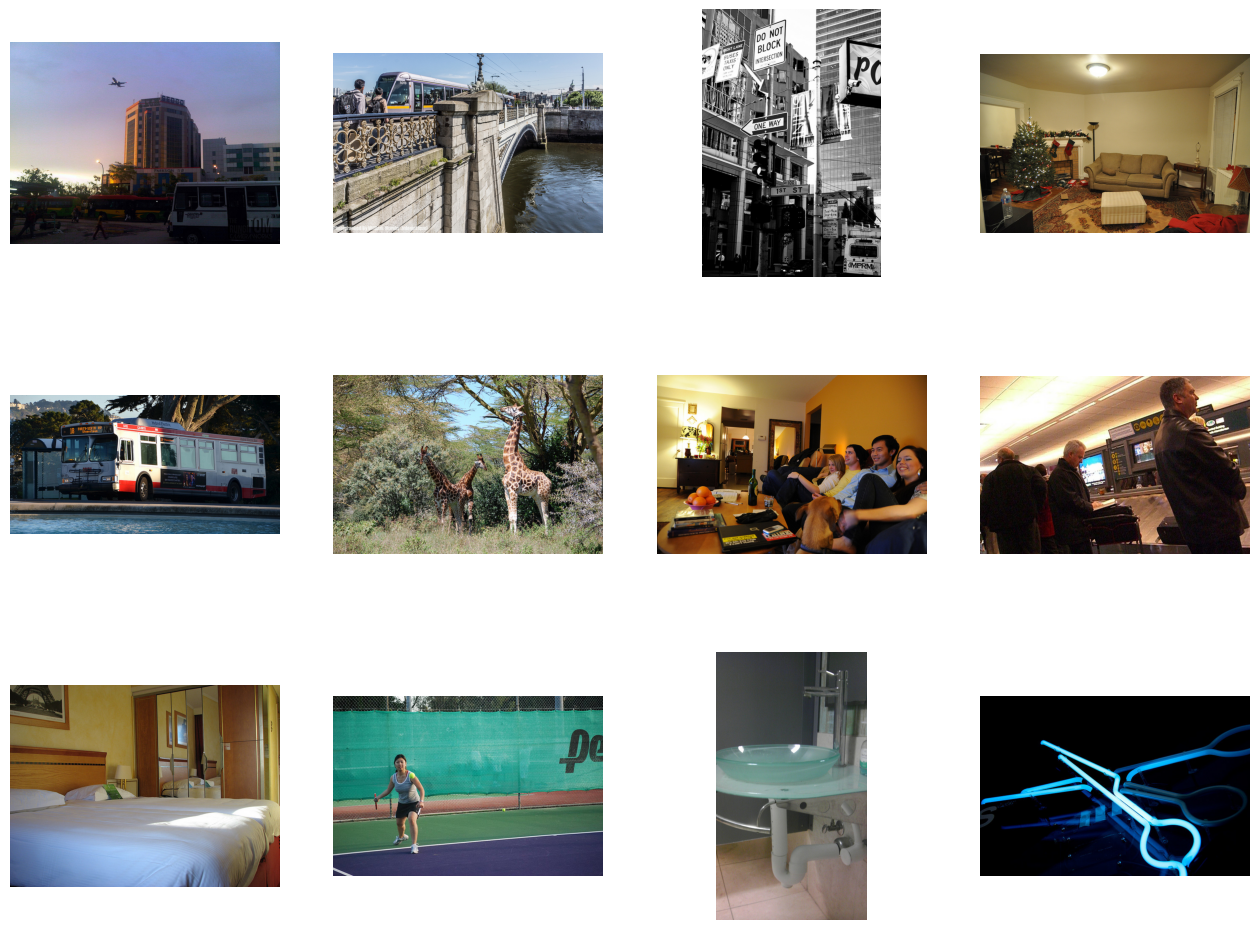

In [ ]:
# import matplotlib.pyplot as plt
# import skimage.io as io

# 랜덤 파일 읽기, imgidss 확인!! -전체코코인지 일부인지
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')
    I = io.imread(img_path)
    plt.imshow(I)
    print( updated_dict[img_path][0])

plt.show()

In [ ]:
import pickle
import tensorflow as tf
from tensorflow.io.gfile import GFile
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
dataset =updated_dict


list(dataset.keys())[:10]


['/content/content/custom_train_coco_30k/000000000025.jpg',
 '/content/content/custom_train_coco_30k/000000000081.jpg',
 '/content/content/custom_train_coco_30k/000000000089.jpg',
 '/content/content/custom_train_coco_30k/000000000092.jpg',
 '/content/content/custom_train_coco_30k/000000000151.jpg',
 '/content/content/custom_train_coco_30k/000000000154.jpg',
 '/content/content/custom_train_coco_30k/000000000165.jpg',
 '/content/content/custom_train_coco_30k/000000000208.jpg',
 '/content/content/custom_train_coco_30k/000000000250.jpg',
 '/content/content/custom_train_coco_30k/000000000294.jpg']

Preprocess and tokenize the captions

In [ ]:
import itertools


# 임시 : sample은 개수

SAMPLE_NUM=10
testsample_dict= dict(itertools.islice(dataset.items(), SAMPLE_NUM))


# sample 쓴다고 가정
# dataset = testsample_dict

Preprocess and tokenize the captions

In [ ]:
from itertools import chain
from tensorflow.keras.preprocessing.text import Tokenizer

# 30K 단어 토큰화 # 15k만들기는 아직 보류

def tokenize_mycaption(dataset, max_words=15000):
  
  flatten_list = list(chain.from_iterable(dataset.values())) #[[1,3],[4,8]] = [1,3,4,8]

  tokenizer = Tokenizer( oov_token='<oov>') # For those words which are not found in word_index
  tokenizer.fit_on_texts(flatten_list)
  total_words = len(tokenizer.word_index) + 1
  print("Vocabulary length: ", total_words)
  print(list(tokenizer.word_index.keys())[:10])
  return tokenizer, total_words

tokenizer, total_words = tokenize_mycaption(dataset, max_words=15000)


Vocabulary length:  15691
['<oov>', 'a', 'on', 'of', 'the', 'in', 'with', 'and', 'is', 'man']


In [ ]:
# dataset 에 <start>, <end> 넣기, LSTM 용


newdataset = {k: ['<start> '   +cap+ ' <end>' for cap in caps] for k,caps in dataset.items()}

print(len(newdataset))
print(list(newdataset.items())[0])
print(len(list(newdataset.values())[0]))

dataset =newdataset


30000
('/content/content/custom_train_coco_30k/000000000025.jpg', ['<start> A giraffe eating food from the top of the tree. <end>', '<start> A giraffe standing up nearby a tree  <end>', '<start> A giraffe mother with its baby in the forest. <end>', '<start> Two giraffes standing in a tree filled area. <end>', '<start> A giraffe standing next to a forest filled with trees. <end>'])
5


In [ ]:
# # 해당 3만개 데이터에 대한 tokenizer 저장  (15691 단어 수)

# import pickle

# # Save the configuration and weights to a file
# with open(f"my_tokenizer_{my_part}.pkl", "wb") as f:
#     pickle.dump({"tokenizer": tokenizer}, f)

In [ ]:
dataset_list = list(dataset)


sample_link = dataset_list[0]


sample_captions = dataset[sample_link]


sample_link, sample_captions

('/content/content/custom_train_coco_30k/000000000025.jpg',
 ['<start> A giraffe eating food from the top of the tree. <end>',
  '<start> A giraffe standing up nearby a tree  <end>',
  '<start> A giraffe mother with its baby in the forest. <end>',
  '<start> Two giraffes standing in a tree filled area. <end>',
  '<start> A giraffe standing next to a forest filled with trees. <end>'])

In [ ]:
# Image Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(
    # featurewise_center=False,
    # samplewise_center=False,
    # featurewise_std_normalization=False,
    # samplewise_std_normalization=False,
    # zca_whitening=False,
    # zca_epsilon=1e-06,
    # rotation_range=0,
    width_shift_range=0.1, # changed
    height_shift_range=0.1, # changed
    # brightness_range=None,
    shear_range=0.1, # changed
    zoom_range=0.1, # changed
    # channel_shift_range=0.0,
    # fill_mode='nearest',
    # cval=0.0,
    horizontal_flip=True, # changed
    vertical_flip=False,
    # rescale=None,
    # preprocessing_function=None,
    # data_format=None,
    # validation_split=0.0,
    # interpolation_order=1,
    # dtype=None
)

In [ ]:
# Encoder 인 Xception 모델 호출, image_feature, imsize, error_imgs 선언, img_preprocess (이미지 사이즈 model 에 맞게 + resize, + 정규화 + feature 추출)


from tensorflow.keras.applications.xception import Xception
from tqdm.notebook import tqdm
import cv2
import numpy as np

model = Xception(include_top=False, pooling='avg',  weights='imagenet')

# model.compile()

image_features = {}

imsize = (299,299)
# dataset.keys()
error_imgs = []
# 윤성(230411/aug : True->False)
def img_preprocess(dataset=dataset,imsize=imsize, model=model, aug =True  ):
# def img_preprocess(dataset=dataset,imsize=imsize, model=model, aug =False  ):
    for img in tqdm(list(dataset.keys())):
        try:
            image = io.imread(img)
            if image.ndim != 3:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

            # Resize each image size 299 x 299 or 224 X 224
            image = cv2.resize(image, (imsize[1], imsize[0]))
            image = np.expand_dims(image, axis=0)
            if aug == True:
              augmented_image = data_gen.flow(image, batch_size=1).next()
              image = augmented_image

            # Normalize image pixels
            image = image / 127.5
            image = image - 1.0

            # Extract features from image
            feature = model.predict(image)
            
            [img] = feature

        except:
            print(f"Failed to process image {img}")
            error_imgs.append[img]

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
# 윤성(230411 주석처리)
# MobileNet Feature extraction 용
# from tensorflow.keras.layers import GlobalAveragePooling2D

# IMAGE_SHAPE=(224, 224, 3)
# mobilenet = tf.keras.applications.MobileNetV3Small(
#     input_shape=IMAGE_SHAPE,
#     include_top=False,
#     include_preprocessing=True)
# mobilenet.trainable=False

# x = mobilenet.output
# x = GlobalAveragePooling2D()(x)

# modified_mobilenetv3small = Model(inputs=mobilenet.input, outputs=x)

# img_preprocess(dataset, imsize =IMAGE_SHAPE, model = modified_mobilenetv3small)


In [ ]:
# 윤성추가(230411)
# model_incep.summary()
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
# from tensorflow.keras.layers import GlobalAveragePooling2D

IMAGE_SHAPE=(224, 224, 3)

vgg16 = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
) 
vgg16.trainable=False

x = vgg16.output
x = GlobalAveragePooling2D()(x)

modified_vgg16 = Model(inputs=vgg16.input, outputs=x)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#윤성추가(230411)
# modified_vgg16.summary()

img_preprocess(dataset, imsize =IMAGE_SHAPE, model = modified_vgg16)
# 뒤에 각모델마다  호출할때 모델 피팅 따로적용해야함

  0%|          | 0/30000 [00:00<?, ?it/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 19ms/step


In [ ]:
# 윤성 07,08,09
import pickle
# Get the tokenizer's configuration and weights
# image_features

# 각자 Sampletrain 별로 저장하기 
# ex) train

# 윤성(230411/aug : True->False)
# with open(f"my_feature_{len(image_features)}_{my_part}.pkl", "wb") as f:
# with open(f"vgg16_feature_{len(image_features)}_aug_True.pkl", "wb") as f:
# with open(f"vgg16_feature_{len(image_features)}_aug_False.pkl", "wb") as f:
with open("vgg16_feature_30000_aug_True.pkl", "wb") as f:  
    pickle.dump({"feature": image_features}, f)

In [ ]:
import pickle

extract =False 

if extract == True:
  pass
# img_preprocess(dataset)
else:
  # /content/drive/MyDrive/3조/features_Xception/my_feature_10000_01.pkl
  # feature 파일 로드, (dict 형태)
  # 더 좋은 알고리즘이 있겠지만 ... 일단 이렇게

  # with open("/content/drive/MyDrive/3조/features_Xception/my_feature_10000_01.pkl", "rb") as f:
  # with open("/content/drive/MyDrive/3조/vgg pkl/vgg16_feature_10000_01.pkl", "rb") as f:  
# 윤성(230411 경로수정)
  # with open("/content/drive/MyDrive/3조/features_VGG16_30K/vgg16_feature_30000_aug_True.pkl", "rb") as f:    
  with open("vgg16_feature_30000_aug_True.pkl", "rb") as f:      
  
  
    load_feature_file = pickle.load(f)


  load_features = list(load_feature_file.values())[0]

  print(type(load_features))
  keys = list(load_features.keys())
  values =list(load_features.values())


  load_feature_dict  = {}

  my_filepath_key =[sample_path+"/"+ key[-16:] for key in keys]

  for i in range(len(keys)):
      load_feature_dict[my_filepath_key[i]] = values[i]


  len(load_feature_dict)

  first_item_key = list(load_feature_dict.keys())[0]
  first_item_value = list(load_feature_dict.values())[0]

  # io.imread(first_item_key)


  # 다시 키를 내경로에 맞게 수정하는 과정 필요


  # plt.imshow(first_item_value)# feature = >이미지 decode 필요한데 불가능한듯. GAN 이나, 추가적인 decoder 모델 필요

  print(first_item_value.shape)

<class 'dict'>
(1, 512)


In [ ]:
print("Image features length: ", len(image_features))

Image features length:  30000


In [ ]:
# testsample_dict

# img_preprocess ( dataset = testsample_dict )


In [ ]:
print(len(image_features))
print(list(image_features.items())[-1])

30000
('/content/content/custom_train_coco_30k/000000581921.jpg', array([[1.35383591e-01, 0.00000000e+00, 3.15629244e-01, 0.00000000e+00,
        1.59665480e-01, 4.26470011e-04, 8.05837661e-02, 0.00000000e+00,
        0.00000000e+00, 4.40263003e-02, 0.00000000e+00, 3.56864482e-02,
        1.63363278e-01, 0.00000000e+00, 1.53798740e-02, 1.37324154e-01,
        5.77748753e-02, 1.36887103e-01, 0.00000000e+00, 5.03024412e-03,
        2.78612282e-02, 3.56025615e-04, 5.80697029e-04, 1.29421756e-01,
        1.18822046e-02, 0.00000000e+00, 1.89785644e-01, 8.26371834e-02,
        5.90596385e-02, 0.00000000e+00, 4.79378760e-01, 4.15650696e-01,
        2.35498667e-01, 1.07186541e-01, 3.48476581e-02, 0.00000000e+00,
        9.74712446e-02, 4.43739370e-02, 0.00000000e+00, 1.73788029e-03,
        0.00000000e+00, 7.38164485e-02, 2.33060956e-01, 3.31287980e-02,
        1.61264434e-01, 3.07128102e-01, 5.27217805e-01, 2.65012053e-03,
        1.60941761e-02, 4.19745654e-01, 1.17354929e-01, 4.02518921e-03

000000000025.jpg
['/content/content/custom_train_coco_30k/000000000025.jpg', '/content/content/custom_train_coco_30k/000000000081.jpg', '/content/content/custom_train_coco_30k/000000000089.jpg', '/content/content/custom_train_coco_30k/000000000092.jpg', '/content/content/custom_train_coco_30k/000000000151.jpg']
55


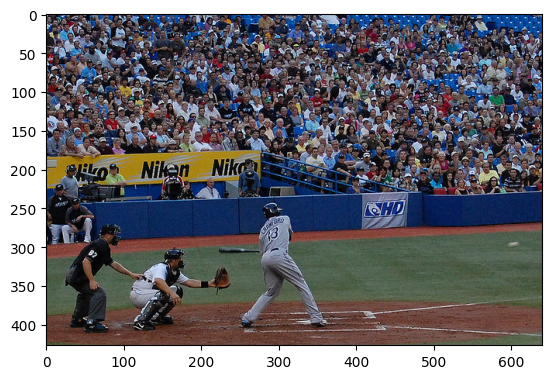

In [ ]:
# 이미지 읽어보기 [0]

print(first_item_key[-16:])

print(my_filepath_key[:5])
print(len(my_filepath_key[0]))

# index [0:9999]
im = io.imread(my_filepath_key[23])

plt.imshow(im)
plt.show()

In [ ]:
dataset[my_filepath_key[23]]

['<start> A baseball game is going on for the crowd.  <end>',
 '<start> A baseball player holding a bat over the top of a base. <end>',
 '<start> The stands are packed as a baseball player in a gray uniform holds a bat as a catcher holds out his mitt. <end>',
 '<start> A man that has a baseball bat standing in the dirt. <end>',
 '<start> A man swinging a bat at a baseball on a field. <end>']

In [ ]:
if load_feature_dict:
  image_features = load_feature_dict


print("Image features length: ", len(image_features))

Image features length:  30000


In [ ]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(dataset)
max_length

50

Make a Data Generator
We have to train our model on 6221 images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for 6221 images is not possible to hold into memory so we will be using a generator method that will yield batches.

The generator will yield the input and output sequence.

For example:¶
The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.

Capture.PNG

In [ ]:
#create input-output sequence pairs from the image description.
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
        #  description 인 경우 10,000개 
            feature = features[key][0]
            # print("features",type(features), len(features), list(features.keys())[0]) #  features 자체는 image_features dict
            # print("feature",type(feature), len(feature))
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    num=0
    # walk through each description for the image
    for desc in desc_list: # desc_list 는 caption의 list를 뜻함
        
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # print(len(seq))
        
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # print("in_seq",in_seq)
            
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]
            # print("out_seq",out_seq, "\n", len(out_seq))
            
            # store
            # append num
            num+=1
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output
    # print("append 한 횟수 :",num)

    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
gen = data_generator(dataset, image_features, tokenizer, max_length)

for i , a in enumerate(gen):
  print(i,":", a[0][0].shape,a[0][1].shape, a[1].shape )
  if i >2 :
    break

# model.fit(gen,epochs,steps_per_epoch)

0 : (49, 512) (49, 50) (49, 15691)
1 : (48, 512) (48, 50) (48, 15691)
2 : (60, 512) (60, 50) (60, 15691)
3 : (58, 512) (58, 50) (58, 15691)


Define CNN-LSTM Model
CNN (Convolution Neural Network)
Technically, deep learning CNN models to train and test, each input image will pass it through a series of convolution layers with filters (Kernals), Pooling, fully connected layers (FC) and apply Softmax function to classify an object with probabilistic values between 0 and 1.

Click here to know more about CNN.

LSTM (Long short-term memory)
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like machine translation, speech recognition, and more. LSTMs are a complex area of deep learning

Click here to know more about LSTM.
Model Architechture
CNN-LSTM model:
CNN is used for extracting features from the image. We will use the pre-trained model Xception.
LSTM will use the information from CNN to help generate a description of the image.
Model structure
model.png

The feature extracted from the image has a size of 2048, with a dense layer, we will reduce the dimensions to 256 nodes.
An embedding layer will handle the text input,followed by the LSTM layer.
Then By merging the output from the above two layers, we will process by the dense layer to make the final prediction. The final layer will contain the number of nodes equal to our vocabulary size.

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention

# define the captioning model
def define_model(total_words, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    # inputs1 = Input(shape=(2048,)) #for Xception (1,2048)
    inputs1 = Input(shape=(512,))# for VGG 512

    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
# train our model
import os

try:
  os.mkdir("models")
except:
  print("models folder already exists")

# testsample_dict
caption_model = define_model(total_words, max_length)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 256)      4016896     ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 512)          0           ['input_3[0][0]']                
                                                                                            

In [ ]:
fit_num=0

BATCH_SIZE = 32


def train_our_model(dataset,batch =BATCH_SIZE, model =caption_model):
  global fit_num
  fit_num+=1

  print('Dataset: ', len(dataset))
  print('Descriptions: train=', len(dataset))
  print('Photos: train=', len(image_features))
  print('Vocabulary Size:', total_words)
  print('Description Length: ', max_length)

  epochs=1
  steps = len(dataset)

  # making a directory models to save our models

  # yield  []
  for i in range(epochs):
      generator = data_generator(dataset, image_features, tokenizer, max_length)
      # model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1, batch_size=BATCH_SIZE)
      history = model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1, batch_size=BATCH_SIZE)      
    # model.fit(generator, epochs=5, steps_per_epoch= steps, verbose=1, batch_size=BATCH_SIZE, validation_set = validation_loss = )      

      model.save("models/model_" + str(i) +str(fit_num)+ ".h5")

fit 실행(epochs)

In [ ]:
train_our_model(dataset)

In [ ]:
import matplotlib.pyplot as plt

# Get the training loss history
# train_loss = caption_model.history['loss']
train_loss = caption_model.history.history['loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training loss
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
caption_model.summary()
from datetime import datetime
current_time = datetime.now()
timestamp = int(current_time.timestamp())
# print(timestamp)



model_save_name  =f"/content/drive/MyDrive/3조/Models/{timestamp}_caption_model.h5"
# print(model_save_name)
# caption_model.save("test_model.h5")
caption_model.save(model_save_name)

In [ ]:
# loaded_model = tf.keras.saving.load_model("/content/drive/MyDrive/3조/Models/model_01_vgg16.h5")
# 윤성(230411)
# loaded_model = tf.keras.saving.load_model("/content/drive/MyDrive/3조/Models/model_01_vgg16_30k_aug(false).h5")
loaded_model = tf.keras.saving.load_model("models/model_01.h5")



loaded_model.summary()

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
img_paths = []
for filename in glob.glob('./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/*.jpg'): #assuming jpg
    # im=Image.open(filename)
    # print(filename)
    # print(im)
    img_paths.append(filename)

    if len(img_paths)>10:
      break
print(img_paths)

In [ ]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            in_text = in_text[:-3]  +"<"+in_text [-3:] + ">"
            break
    return in_text

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# 윤성 (230412 앞에 있다)

# IMAGE_SHAPE=(224, 224, 3)

# vgg16 = tf.keras.applications.vgg16.VGG16(
#     include_top=False,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation='softmax'
# ) 
# vgg16.trainable=False

# x = vgg16.output
# x = GlobalAveragePooling2D()(x)

# modified_vgg16 = Model(inputs=vgg16.input, outputs=x)

In [ ]:
photo = extract_features(img_paths[2], modified_vgg16)
img = Image.open(img_paths[2])
description = generate_desc(caption_model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
img_paths = []
for filename in glob.glob('./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/*.jpg'): #assuming jpg
    # im=Image.open(filename)
    # print(filename)
    # print(im)
    img_paths.append(filename)

    if len(img_paths)>10:
      break



print(img_paths)

In [ ]:
len(img_paths)

In [ ]:
# 랜덤 파일 읽기, imgidss 확인!! -전체코코인지 일부인지
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')
    I = io.imread(img_path)
    plt.imshow(I)
    print( updated_dict[img_path][0])

plt.show()

In [ ]:
img_paths


In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

# xception_model = Xception(include_top=False, pooling="avg")
# for i, image in enumerate(img_paths):
for i, image in enumerate(next_pix[0:12]):
  
  photo = extract_features(image,modified_vgg16 )
  img = Image.open(image)
  description = generate_desc(caption_model, tokenizer, photo, 49)
  print("\n")
  sp = plt.subplot(4, 4, i + 1)
  sp.axis('Off')
  plt.imshow(img)
  print(description)

plt.show()